In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vincenty import vincenty


from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, silhouette_score 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

In [2]:
#Import natural disaster data
raw = pd.read_csv('natural_disaster_human_mobility.csv')

In [3]:
#Switch latitude and longtitude columns, rename and reorder, dataframe
df = raw
df = df.rename(columns = {'disaster.event': 'event', 'user.anon': 'user', 'latitude': 'long', 'longitude.anon': 'lat'})
df = df[['event', 'user', 'lat', 'long', 'time']]
df['time'] = pd.DatetimeIndex(df['time'])

In [4]:
#Clean event names
event_name={
'01_Wipha':'Wipha',
'02_Halong': 'Halong',
'06_Kalmaegi': 'Kalmaegi',
'08_Rammasun_Manila': 'Manila',
'12_Bohol': 'Bohol',
'13_Iquique': 'Iquidue',
'14_Napa': 'Napa',
'21_Norfolk': 'Norfolk',
'22_Hamburg': 'Hamburg',
'23_Atlanta': 'Atlanta',
'31_Phoenix': 'Phoenix',
'32_Detroit': 'Detroit',
'33_Baltimore': 'Baltimore',
'41_AuFire1': 'Australia1',
'42_AuFire2': 'Australia2'}

df['event_name'] = df['event'].map(event_name)

In [5]:
#Add event type
event_type={
'Wipha': 'Typhoon',
'Halong': 'Typhoon',
'Kalmaegi': 'Typhoon',
'Manila': 'Typhoon',
'Bohol': 'Earthquake',
'Iquidue': 'Earthquake',
'Napa': 'Earthquake',
'Norfolk': 'Winter_Storm',
'Hamburg': 'Winter_Storm',
'Atlanta': 'Winter_Storm',
'Phoenix': 'Thunderstorm',
'Detroit': 'Thunderstorm',
'Baltimore': 'Thunderstorm',
'Australia1': 'Wildfire',
'Australia2': 'Wildfire'}    

df['event_type'] = df['event_name'].map(event_type)
df = df.drop(columns = ['event'])

In [6]:
df.groupby('event_name').count()

,user,lat,long,time,event_type
event_name,,,,,
Atlanta,157178,157178,157178,157178,157178
Australia1,43275,43275,43275,43275,43275
Australia2,64370,64370,64370,64370,64370
Baltimore,328880,328880,328880,328880,328880
Bohol,114606,114606,114606,114606,114606
Detroit,765349,765349,765349,765349,765349
Halong,171559,171559,171559,171559,171559
Hamburg,15053,15053,15053,15053,15053
Iquidue,15297,15297,15297,15297,15297


In [7]:
#Remove Wipia, has bad data 300,000 enteries!
df = df.loc[df['event_name'] != 'Wipha']

In [8]:
#Add date column, drop time column
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [9]:
#Disaster day function and key
def disaster_day(event_name, date):
    if event_name == 'Wipha' and str(date) == '2013-10-11 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-12 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-13 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-14 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-15 00:00:00':
        return True    
    elif event_name == 'Wipha' and str(date) == '2013-10-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-11 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-12 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-13 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-14 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-15 00:00:00':
        return True      
    elif event_name == 'Manila' and str(date) == '2014-07-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-17 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-18 00:00:00':
        return True  
    elif event_name == 'Bohol' and str(date) == '2013-10-15 00:00:00':
        return True 
    elif event_name == 'Iquidue' and str(date) == '2014-04-01 00:00:00':
        return True     
    elif event_name == 'Napa' and str(date) == '2014-08-24 00:00:00':
        return True   
    elif event_name == 'Atlanta' and str(date) == '2014-01-08 00:00:00':
        return True   
    elif event_name == 'Detroit' and str(date) == '2014-09-20 00:00:00':
        return True   
    elif event_name == 'Australia1' and str(date) >= '2013-10-17 00:00:00':
        return True
    else:
        return False

In [10]:
def wizzard(data):
    #Apply disaster day fucntion
    data['disaster_day'] = data.apply(lambda row: disaster_day((row['event_name']), (row['date'])), axis = 1)
    
    #Create diststance from center column
    data['dist_cent'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (data['lat'].mean(),  data['long'].mean())), axis=1) 
    
    #Sort data by time
    data = data.groupby(['event_name', 'user'], group_keys=False)
    data = data.apply(lambda _data: _data.sort_values(by=['time']))
    
    #Generate distance between tweets column
    data['lat_1'] = data['lat'].shift()
    data['long_1'] = data['long'].shift()
    data['dist_mi'] = data.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

    #Create tweet velocity column
    data['time_diff'] = data['time'].diff()
    data['time_diff_hour'] = data['time_diff']/np.timedelta64(1, 'h')
    data['time_diff_day'] = data['time_diff']/np.timedelta64(1, 'D')
    data['velocity_mph'] = data['dist_mi']/data['time_diff_hour']
    #data['velocity_mph'] = data.loc[data['velocity_mph'] != 0]
    #data['velocity_mph'] = data['velocity_mph'].astype(float)
    #data['dist_cent'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    #(data['lat'].mean(),  data['long'].mean())), axis=1)    
    
    #Delete first row in every groupby
    data = data.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])
    
    #Turn infiniti values into NaNs and drop NaNs
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    return data

In [216]:
#Call wizzard function here
Aus1 = df.loc[df['event_name'] == 'Australia1']
Aus1 = wizzard(Aus1)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [220]:
#Aggregating function
def aggregate(data):
    data = data.loc[data['velocity_mph'] <100]
    data['tweets'] = data.groupby(['event_name', 'disaster_day','date']).cumcount()
    data = data.groupby(['event_name', 'disaster_day', 'date']).agg({'velocity_mph': ['mean'],\
                                                          #'dist_cent2' : ['mean'],\
                                                          'dist_mi' : ['mean'],\
                                                          'time_diff_day' : ['mean'],\
                                                          'lat' : ['mean'],\
                                                          'long' : ['mean'],\
                                                          'tweets' : ['max']})
    data = data.reset_index()
    data.columns = list(data.columns.levels[0][-3:][::-1]) + list(data.columns.levels[0][:-3])

    data['dist_cent3'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (data['lat'].mean(),  data['long'].mean())), axis=1) 

    data = data.loc[data['date'] != '2013-11-01 00:00:00']
    return data
#Aus5.groupby('disaster_day').mean()
#plt.plot(Aus5['date'], Aus5['dist_cent3'])

In [222]:
#Call aggregate function here
Aus1_1 = aggregate(Aus1)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Clustering function
def cluster(data):
#Select features and target varaibles
X = data.iloc[:, 3:]
y = data.iloc[:, 1]

#Scale features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


#Perform K means
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1)
km.fit_transform(X)
pred_disaster = km.labels_ 


#Perform DBSCAN
dbscan = DBSCAN(eps=100)
dbscan.fit(X)
dbscan_lab = dbscan.labels_


#Add new columns to aggregated dataframe
Aus5['pred_disaster'] = pred_disaster.astype(bool)
Aus5['pred_disaster_pca'] = pred_disaster_pca.astype(bool)
Aus5['pred_disaster_dbscan'] = dbscan_lab.astype(bool)
Aus5

In [ ]:
#Confusion Matrix
km_con = confusion_matrix(Aus5['disaster_day'], Aus5['pred_disaster'])
sns.heatmap(km_con, cmap=plt.cm.Blues, annot=True, fmt='g', square=True)

plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted Disaster Day')
plt.ylabel('Actual Disaster Day')

print("ROC AUC:", roc_auc_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Precision:", precision_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Recall:", recall_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Accuracy:", accuracy_score(Aus5['disaster_day'], Aus5['pred_disaster']))

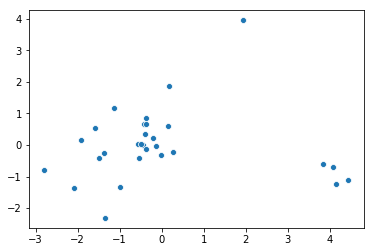

In [189]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X_std)
pcafeatures = pca.transform(X_std)

pca.explained_variance_ratio_

comp_1 = []
comp_2 = []
for i in range(len(pcafeatures)):
    comp_1.append(pcafeatures[i][0])
    comp_2.append(pcafeatures[i][1])
    
cluster_df = pd.DataFrame(
    {'Component 1': comp_1,
     'Component 2': comp_2,
     'Disaster Day': disaster_day})

sns.scatterplot(x=comp_1, y=comp_2)

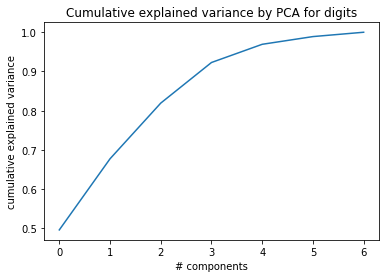

In [175]:
#Cumulative PCA Variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');

In [190]:
#Perform K means
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1)
km.fit_transform(X)
pred_disaster = km.labels_ 

km_pca = KMeans(n_clusters=num_clusters,random_state=10,n_init=1)
km_pca.fit_transform(pcafeatures)
pred_disaster_pca = km_pca.labels_ 


In [188]:
silhouette_score(X, pred_disaster) 

0.7170749948605315

In [177]:
#Perform DBSCAN
dbscan = DBSCAN(eps=100)
dbscan.fit(X)
dbscan_lab = dbscan.labels_

In [199]:
Aus5['pred_disaster'] = pred_disaster.astype(bool)
Aus5['pred_disaster_pca'] = pred_disaster_pca.astype(bool)
Aus5['pred_disaster_dbscan'] = dbscan_lab.astype(bool)
Aus5

,event_name,disaster_day,date,velocity_mph,dist_mi,time_diff_day,lat,long,tweets,dist_cent3,pred_disaster,pred_disaster_dbscan,pred_disaster_pca
0,Australia1,False,2013-10-08,1.437664,0.620010,0.048037,-22.528696,151.066157,756,1.790604,True,True,False
1,Australia1,False,2013-10-09,1.540342,1.261037,0.179133,-22.516768,151.089731,933,3.231604,True,False,False
2,Australia1,False,2013-10-10,1.761490,1.726462,0.233838,-22.511779,151.106383,1247,4.691040,True,False,False
3,Australia1,False,2013-10-11,1.385495,1.686800,0.372423,-22.536688,151.068533,1031,0.937611,True,False,False
4,Australia1,False,2013-10-12,1.311047,2.313706,0.351211,-22.515370,151.124815,1115,5.937979,True,False,False
5,Australia1,False,2013-10-13,0.866418,1.313500,0.454933,-22.533218,151.090781,1084,1.919408,True,False,False
6,Australia1,False,2013-10-14,0.903163,1.695604,0.609066,-22.531410,151.090530,901,2.014178,True,False,False
7,Australia1,False,2013-10-15,1.228567,1.756498,0.543368,-22.539933,151.089635,985,1.525846,True,False,False
8,Australia1,False,2013-10-16,1.334240,1.881142,0.610245,-22.540385,151.035165,947,4.112867,True,False,False
9,Australia1,True,2013-10-17,1.468244,1.904260,0.611075,-22.536159,151.056829,1361,2.007435,True,True,False


ROC AUC: 0.375
Precision: 0.625
Recall: 0.75
Accuracy: 0.5172413793103449


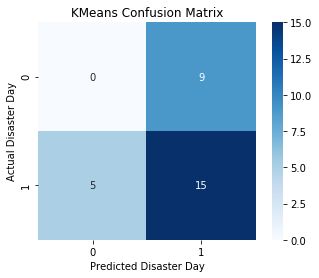

In [200]:
km_con = confusion_matrix(Aus5['disaster_day'], Aus5['pred_disaster'])
sns.heatmap(km_con, cmap=plt.cm.Blues, annot=True, fmt='g', square=True)

plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted Disaster Day')
plt.ylabel('Actual Disaster Day')

print("ROC AUC:", roc_auc_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Precision:", precision_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Recall:", recall_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Accuracy:", accuracy_score(Aus5['disaster_day'], Aus5['pred_disaster']))

ROC AUC: 0.6694444444444444
Precision: 0.9
Recall: 0.45
Accuracy: 0.5862068965517241


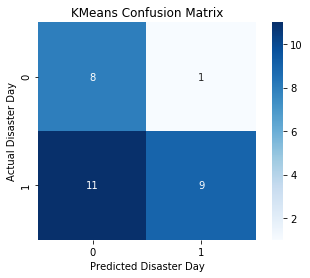

In [201]:
dbscan_con = confusion_matrix(Aus5['disaster_day'], Aus5['pred_disaster_dbscan'])
sns.heatmap(dbscan_con, cmap=plt.cm.Blues, annot=True, fmt='g', square=True)

plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted Disaster Day')
plt.ylabel('Actual Disaster Day')

print("ROC AUC:", roc_auc_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Precision:", precision_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Recall:", recall_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Accuracy:", accuracy_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))

ROC AUC: 0.6694444444444444
Precision: 0.9
Recall: 0.45
Accuracy: 0.5862068965517241


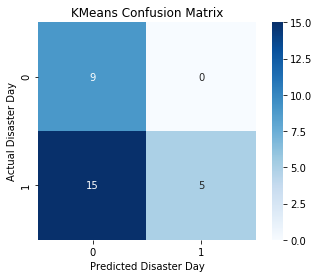

In [202]:
km_pca = confusion_matrix(Aus5['disaster_day'], Aus5['pred_disaster_pca'])
sns.heatmap(km_pca, cmap=plt.cm.Blues, annot=True, fmt='g', square=True)

plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted Disaster Day')
plt.ylabel('Actual Disaster Day')

print("ROC AUC:", roc_auc_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Precision:", precision_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Recall:", recall_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))
print("Accuracy:", accuracy_score(Aus5['disaster_day'], Aus5['pred_disaster_dbscan']))

In [ ]:
km_con = confusion_matrix(Aus5['disaster_day'], Aus5['pred_disaster'])
sns.heatmap(km_con, cmap=plt.cm.Blues, annot=True, fmt='g', square=True)

plt.title('KMeans Confusion Matrix')
plt.xlabel('Predicted Disaster Day')
plt.ylabel('Actual Disaster Day')

print("ROC AUC:", roc_auc_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Precision:", precision_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Recall:", recall_score(Aus5['disaster_day'], Aus5['pred_disaster']))
print("Accuracy:", accuracy_score(Aus5['disaster_day'], Aus5['pred_disaster']))

In [52]:
#helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s, label = two_comp['Disaster Day'])
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
            

#two_comp2 = two_comp.iloc[:,0:2].as_matrix()           
            
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit_transform(X_std)
display_cluster(X_std,km,num_clusters)
km.labels_            
            

In [51]:
j = km.labels_

two_comp = pd.DataFrame(
    {'Component 1': x,
     'Component 2': y,
     'Cluster': j,
     'Disaster Day': z})


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

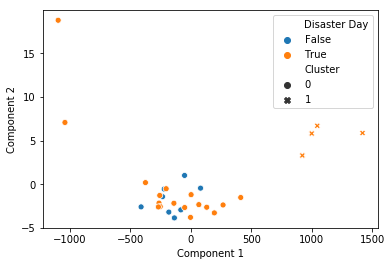

In [35]:
sns.scatterplot(x=two_comp['Component 1'], y=two_comp['Component 2'], hue =two_comp['Disaster Day'], style = two_comp['Cluster'])

In [ ]:
napa = df.loc[df['event_name'] == 'Napa']
napa = wizzard(napa)

In [ ]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [ ]:
plt.plot([KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,10)])

In [ ]:
#Pickle data
redo_pickle = False
if redo_pickle == True:
    with open('df.pickle','wb') as f:
        pickle.dump(df,f)
#if redo_pickle == False:
    #with open('df.pickle','rb') as f:
        #df = pickle.load(f)

In [ ]:
#Add natural disaster tag
'Wipha' and '2013-10-11', '2013-10-12', '2013-10-13', '2013-10-14', '2013-10-15', '2013-10-16'
#'Halong'
#'Kalmaegi'
'Manila' and '2014-7-11', '2014-7-12', '2014-7-13', '2014-7-14', '2014-7-15', '2014-7-16', '2014-7-17', '2014-7-18'
'Bohol' and '2013-10-15'
'Iquidue'and '2014-04-01'
'Napa' and '2014-08-24
'Norfolk'
'Hamburg'
'Atlanta' '2014-01-28'
'Phoenix': 
'Detroit': '2014-09-20'
'Baltimore': 
'Australia1': 2013-10-17, 2013-10-28
'Australia2': 

    

In [ ]:
#Sort data by time
df_small = df_small.groupby(['event_name', 'user'], group_keys=False)
df_small = df_small.apply(lambda _df_small: _df_small.sort_values(by=['time']))

In [ ]:
#Generate distance between tweets column
df_small['lat_1'] = df_small['lat'].shift()
df_small['long_1'] = df_small['long'].shift()
df_small['dist_mi'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

In [ ]:
#Delete first row in every groupby
df_small = df_small.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])

In [ ]:
#Create tweet velocity column
df_small['time_diff'] = df_small['time'].diff()
df_small['time_diff_hour'] = df_small['time_diff']/np.timedelta64(1, 'h')
df_small['time_diff_day'] = df_small['time_diff']/np.timedelta64(1, 'D')
df_small['velocity_mph'] = df_small['dist_mi']/df_small['time_diff_hour']
df_small['dist_cent'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    (df_small['lat'].mean(), df_small['long'].mean())), axis=1)

In [ ]:
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-18 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-19 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-20 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-21 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-22 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-23 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-24 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-25 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-26 00:00:00':
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-27 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-28 00:00:00':
        return True
    elif event_name == 'Australia1' and str(date) == '2013-10-29 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-30 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-31 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-01 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-02 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-03 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-04 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-11-06 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-07 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True      
    elif event_name == 'Australia1' and str(date) == '2013-11-05 00:00:00':
        return True 

In [ ]:
Aus5 = Aus1
Aus5 = Aus5.loc[Aus5['velocity_mph'] <100]
Aus5['tweets'] = Aus5.groupby(['event_name', 'disaster_day','date']).cumcount()
Aus5 = Aus5.groupby(['event_name', 'disaster_day', 'date']).agg({'velocity_mph': ['mean'],\
                                                          #'dist_cent2' : ['mean'],\
                                                          'dist_mi' : ['mean'],\
                                                          'time_diff_day' : ['mean'],\
                                                          'lat' : ['mean'],\
                                                          'long' : ['mean'],\
                                                          'tweets' : ['max']})
Aus5 = Aus5.reset_index()
Aus5.columns = list(Aus5.columns.levels[0][-3:][::-1]) + list(Aus5.columns.levels[0][:-3])

Aus5['dist_cent3'] = Aus5.apply(lambda row: vincenty((row['lat'], row['long']), \
                                    (Aus5['lat'].mean(),  Aus5['long'].mean())), axis=1) 

Aus5 = Aus5.loc[Aus5['date'] != '2013-11-01 00:00:00']
Aus5
#Aus5.groupby('disaster_day').mean()
#plt.plot(Aus5['date'], Aus5['dist_cent3'])